In [1]:
%cd /content/drive/My Drive/Notebooks/Projects/Palmprint Recognition/

/content/drive/My Drive/Notebooks/Projects/Palmprint Recognition


In [2]:
%pwd

'/content/drive/My Drive/Notebooks/Projects/Palmprint Recognition'

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [0]:
filepath = "IITD Palmprint V2/Left/001_1.JPG"

blurSigma = 1.0
otsuThreshold = 0

erodeMask = np.ones((31, 31)).astype(np.uint8)
dilateMask = np.ones((35, 35)).astype(np.uint8)

freqThreshold = 10

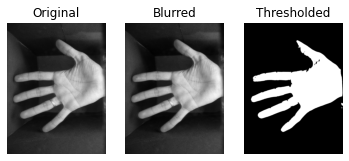

In [5]:
original = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

blurred = cv2.GaussianBlur(original, (0, 0), blurSigma)
retval, thresholded = cv2.threshold(blurred, otsuThreshold, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

fig, aarr = plt.subplots(1, 3)

aarr[0].imshow(original, cmap = "gray")
aarr[0].set_title("Original")
aarr[0].axis("off")

aarr[1].imshow(blurred, cmap = "gray")
aarr[1].set_title("Blurred")
aarr[1].axis("off")

aarr[2].imshow(thresholded, cmap = "gray")
aarr[2].set_title("Thresholded")
aarr[2].axis("off")

plt.show()

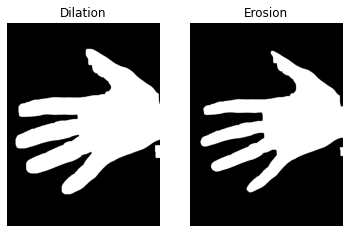

In [6]:
dilated = cv2.dilate(thresholded, dilateMask)
eroded = cv2.erode(dilated, erodeMask)

fig, aarr = plt.subplots(1, 2)

aarr[0].imshow(dilated, cmap = "gray")
aarr[0].set_title("Dilation")
aarr[0].axis("off")

aarr[1].imshow(eroded, cmap = "gray")
aarr[1].set_title("Erosion")
aarr[1].axis("off")

plt.show()

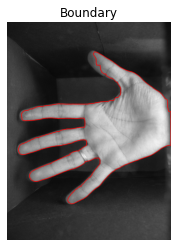

In [7]:
contour, hierarchy = cv2.findContours(eroded, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

area = [cv2.contourArea(con) for con in contour]
order = np.argmax(area)
contour = contour[order]

boundary = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
cv2.drawContours(boundary, contour, -1, (255, 0, 0), 3)

plt.imshow(boundary)
plt.title("Boundary")
plt.axis("off")
plt.show()

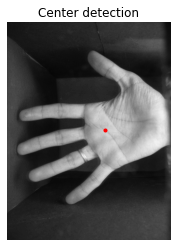

In [8]:
moments = cv2.moments(contour)
center = [moments['m10'] // moments['m00'], moments['m01'] // moments['m00']]

plt.imshow(original, cmap = "gray")
plt.plot(center[0], center[1], "ro", markersize = 3)
plt.title("Center detection")
plt.axis("off")
plt.show()

In [0]:
contour = contour[:, 0, :]
distance = np.sqrt(np.sum((contour - center) ** 2, axis = 1)).reshape(-1)

In [0]:
freq = np.fft.rfft(distance)
newFreq = np.concatenate([freq[:freqThreshold], 0 * freq[freqThreshold:]])

newDistance = np.fft.irfft(newFreq)

[]

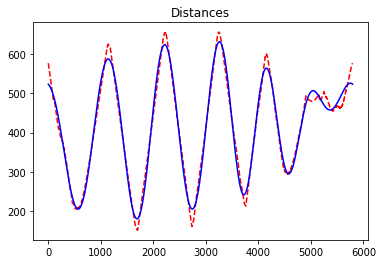

In [11]:
plt.plot(distance, "r--")
plt.plot(newDistance, "b-")
plt.title("Distances")
plt.plot()

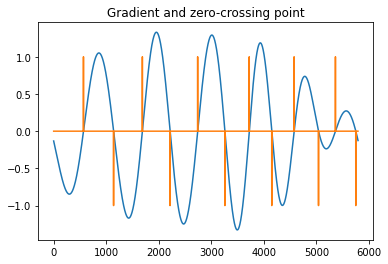

In [12]:
derivated = np.diff(newDistance)
zeroCross = np.diff(np.sign(derivated)) / 2

plt.plot(derivated)
plt.plot(zeroCross)
plt.title("Gradient and zero-crossing point")
plt.show()

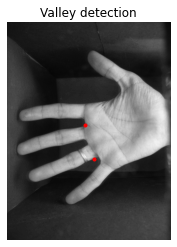

In [13]:
valley = contour[np.where(zeroCross > 0)[0]]

order = np.argsort(valley[:, 0])
valley = valley[order]
valley = valley[:3]

order = np.argsort(valley[:, 1])
valley = valley[[order[0], order[2]]]

plt.imshow(original, cmap = "gray")
plt.plot(valley[:, 0], valley[:, 1], "ro", markersize = 3)
plt.title("Valley detection")
plt.axis("off")
plt.show()

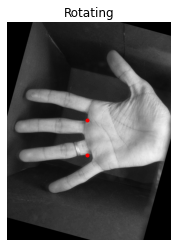

In [14]:
valley0, valley1 = valley
phi = - 90 + np.arctan2((valley1 - valley0)[1], (valley1 - valley0)[0]) * 180 / np.pi

R = cv2.getRotationMatrix2D(tuple(center), phi, 1)
rotated = cv2.warpAffine(original, R, original.shape[::-1])

valley0 = (np.dot(R[:, :2], valley0) + R[:, -1]).astype(np.int)
valley1 = (np.dot(R[:, :2], valley1) + R[:, -1]).astype(np.int)

plt.imshow(rotated, cmap = "gray")
plt.plot(valley0[0], valley0[1], "ro", markersize = 3)
plt.plot(valley1[0], valley1[1], "ro", markersize = 3)
plt.title("Rotating")
plt.axis("off")
plt.show()

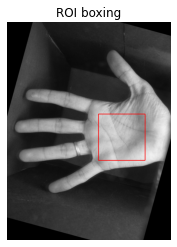

In [15]:
rect0 = (valley0[0] + 2 * (valley1[1] - valley0[1]) // 6, valley0[1] - (valley1[1] - valley0[1]) // 6)
rect1 = (valley1[0] + 10 * (valley1[1] - valley0[1]) // 6, valley1[1] + (valley1[1] - valley0[1]) // 6)

boxed = cv2.cvtColor(rotated, cv2.COLOR_GRAY2BGR)
cv2.rectangle(boxed, rect0, rect1, (255, 0, 0), 3)

plt.imshow(boxed, cmap = "gray")
plt.title("ROI boxing")
plt.axis("off")
plt.show()

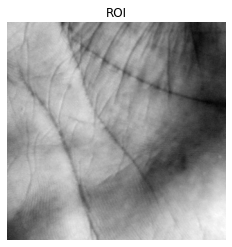

In [16]:
roi = rotated[rect0[1]:rect1[1], rect0[0]:rect1[0]]

plt.imshow(roi, cmap = "gray")
plt.title("ROI")
plt.axis("off")
plt.show()